# Outils

Importations :

In [ ]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random

Outils :

In [ ]:
def calculate_radius(distance, angle):

    radius = distance * np.tan(angle)
    return radius


def detect_target(target_position, beam_position, beam_radius):

    distance = np.linalg.norm(target_position - beam_position)
    return distance <= beam_radius

# Recherche point fixe

Recherche initiale :

In [ ]:
def make_spiral_path(window_size, start_point, step):

    point = start_point
    list_points = [point.copy()]

    direction = 1
    for side_length in range(1, window_size//step + 1):
        for i in range(side_length):
            point[0] += direction * step
            list_points.append(point.copy())
        for j in range(side_length):
            point[1] += direction * step
            list_points.append(point.copy())
        direction *= -1

    return list_points


def search_path(path, beam_radius, target_position):

    for rank in range(len(path)):
        beam_position = path[rank]
        if detect_target(target_position, beam_position, beam_radius):
            return beam_position, rank
    return None


def acquisition(window_size, distance, initial_angle, target_position, resolution):

    list_centers = []
    list_radii = []
    list_spirals = []

    start_point = np.array([window_size//2, window_size//2])
    beam_radius = calculate_radius(distance, initial_angle)
    step = int(sqrt(2)*beam_radius)

    while beam_radius > (resolution / 2):

        path = make_spiral_path(window_size, start_point, step)
        start_point, index = search_path(path, beam_radius, target_position)
        # print(path[:index + 1])
        list_centers.append(start_point.copy())
        list_radii.append(beam_radius)
        cut_path = path[:index] + [start_point.copy()]
        list_spirals.append(cut_path.copy())

        beam_radius /= 2
        step = int(sqrt(2)*beam_radius)

    return start_point, list_centers, list_radii, list_spirals


def plot_acquisition(window_size, list_centers, list_radii, list_spirals, target_position):

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(12500, 15000)
    ax.set_ylim(4000, 6500)
    ax.set_aspect('equal')

    # Tracé des cercles
    for center, radius, spiral in zip(list_centers, list_radii, list_spirals):
        ax.plot(*zip(*spiral), 'g-', alpha=0.5)  # Plot spiral in green
        cercle = plt.Circle(center, radius, color='b', fill=False, linestyle="dashed", alpha=0.5)
        ax.add_patch(cercle)
        ax.plot(*center, 'go', markersize=5)  # Affichage des centres en vert

    # Tracé du point Q
    ax.plot(*target_position, 'ro', markersize=4, label="Point Q (cible)")

    # Légende et affichage
    plt.legend()
    plt.title("Affichage des cercles et du point Q")
    plt.grid(True)
    plt.show()

Tests :

In [ ]:
# Test pour pointing et acquisition :

window_size = 20000
distance = 10000
angle = 0.15
target_position = np.array([13325, 4802])
resolution = 10

start_point, list_centers, list_radii, list_spirals = acquisition(window_size, distance, angle, target_position, resolution)

plot_acquisition(window_size, list_centers, list_radii, list_spirals, start_point)


KeyboardInterrupt: 

# Déplacement

Déplacement aléatoire de l'AUV :

In [ ]:
def move_auv(current_point, dt, noise) : # k la "force du bruit"

    x, y = current_point[0]
    vx, vy = current_point[1]

    new_x = x + vx*dt + random.gauss(0, noise*vx*dt)
    new_y = y + vy*dt + random.gauss(0, noise*vy*dt)
    new_vx = (new_x - x) / dt
    new_vy = (new_y - y) / dt
    return np.array([new_x, new_y]), np.array([new_vx, new_vy])


def make_points_list(initial_position, initial_speed, duration, dt, noise):
    current_point = (initial_position, initial_speed)
    points_list = [current_point]
    for i in range (0, duration) :
        current_point = move_auv(current_point, dt, noise)
        points_list.append(current_point)
    return points_list

def search_path_movement(path, beam_radius, points_list):

    for index in range(len(path)):
        beam_position = path[index]
        target_position = points_list[index][0]
        if detect_target(target_position, beam_position, beam_radius):
            return beam_position, index
    return None

def acquisition_movement(window_size, distance, initial_angle, target_position, target_speed, dt, noise, resolution):

    list_centers = []
    list_radii = []
    list_spirals = []
    current_position = target_position.copy()
    current_speed = target_speed.copy()

    start_point = np.array([window_size//2, window_size//2])
    beam_radius = calculate_radius(distance, initial_angle)
    step = int(sqrt(2)*beam_radius)

    while beam_radius > (resolution / 2):

        path = make_spiral_path(window_size, start_point, step)
        points_list = make_points_list(current_position, current_speed, len(path), dt, noise)

        start_point, index = search_path_movement(path, beam_radius, points_list)

        # print(path[:index + 1])
        list_centers.append(start_point.copy())
        list_radii.append(beam_radius)
        cut_path = path[:index] + [start_point.copy()]
        list_spirals.append(cut_path.copy())

        current_position, current_speed = points_list[index]

        beam_radius /= 2
        step = int(sqrt(2)*beam_radius)

    return start_point, list_centers, list_radii, list_spirals

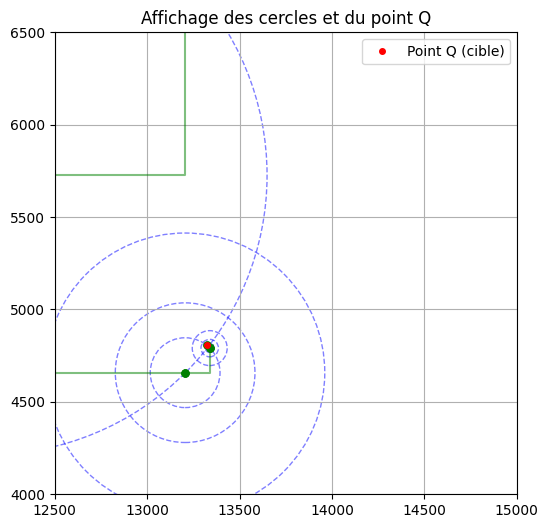

In [ ]:
# Test pour pointing et acquisition :

window_size = 20000
distance = 10000
angle = 0.15
target_position = np.array([13325, 4802])
target_speed = np.array([0, 0])
dt = 1
noise = 0.1
resolution = 10

start_point, list_centers, list_radii, list_spirals = acquisition_movement(window_size, distance, angle, target_position, target_speed, dt, noise, resolution)

plot_acquisition(window_size, list_centers, list_radii, list_spirals, start_point)


Fait :
    pointing : parcours en spirale d'un plan à une distance d avec un faisceau d'angle alpha en recherche d'un auv fixe
    acquisition de l'auv

    mouvement de l'auv

A faire :

    ajout du mouvement de l'auv
        mise à jour des pointing et acquisition
        ajout du tracking

    implémentation de la puissance reçue pour détecter l'auv

    ajout du bruit du milieu / diffusion de l'eau
        filtre de kalman
        mise à jour du pat avec bruit